In [1]:
import os
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from ast import literal_eval
from scipy.signal.windows import tukey, nuttall
from scipy.signal import stft, istft
from sklearn.decomposition import NMF
from IPython.display import Audio
from librosa.core import cqt, icqt

In [2]:
def hamming_window(N):
    # Definición de la ventana hamming de modo que se pueda generar para un
    # largo de ventana definido
    return np.asarray([0.53836 - 0.46164*np.cos((2*np.pi*i)/N)
                       for i in range(int(N))])


def hann_window(N):
    # Definición de la ventana hamming de modo que se pueda generar para un
    # largo de ventana definido
    return np.asarray([0.5 - 0.5*np.cos((2*np.pi*i)/N)
                       for i in range(int(N))])


def wiener_filter(X, WiHi, W, H, alpha=1):
    '''Aplicación de filtro de Wiener para las componentes obtenidas a 
    partir de la descomposición NMF. Está dada por:
    M_i = (WiHi) ** a / (sum_{i} (WiHi) ** a)
    
    Parameters
    ----------
    X : ndarray
        Señal a descomponer mediante NMF.
    WiHi : ndarray
        Componente i de la descomposición NMF.
    W : ndarray
        Matriz que contiene la información espectral de las componentes.
    H : ndarray
        Matriz que contiene la información temporal de las componentes.
    alpha : int, optional
        Exponente utilizado para cada componente. Por defecto es 1.
    '''
    # Definición del WH
    WH_alpha = np.zeros(X.shape)
    
    for i in range(W.shape[1]):
        WH_alpha += np.outer(W[:,i], H[i]) ** alpha
        
    # Obteniendo la máscara
    mask = np.divide(WiHi ** alpha, WH_alpha + 1e-21)
    
    # Aplicando la máscara al espectrograma original, se obtiene el resultado
    # final del proceso de separación de fuentes
    return mask * X


def raised_cosine_modified(N, beta):
    '''Creación de una ventana tipo pulso coseno elevado.
    
    Parameters
    ----------
    N : int
        Cantidad de puntos de la ventana.
    beta : float
        Parámetro de la función coseno elevado para la apertura de la ventana.
        
    Returns
    -------
    rc_out : ndarray
        Ventana pulso coseno elevado de N puntos con el valor de beta ingresado
    '''
    # Definición de la frecuencia f
    f = np.linspace(-1/2, 1/2, N)
    
    # Control de parámetro para beta
    if beta <= 0:
        beta = 0
    elif beta >= 1:
        beta = 1
    
    # Definición del vector de salida
    rc_out = np.array([])
    
    # Para punto f
    for i in f:
        if abs(i) <= (1 - beta)/2:
            rc_out = np.concatenate((rc_out, [1]))
        elif (1 - beta)/2 < abs(i) <= (1 + beta)/2:
            to_append =  np.cos(np.pi / beta * (abs(i) - (1 - beta)/2))
            rc_out = np.concatenate((rc_out, [to_append]))
        else:
            rc_out = np.concatenate((rc_out, [0]))
            
    return rc_out


def raised_cosine_fading(N, beta, side='right'):
    ''' Creacion de una ventana de desvanecimiento basada en coseno elevado.
    
    Parameters
    ----------
    N : int
        Cantidad de puntos de la ventana.
    beta : float
        Parámetro de la función coseno elevado para la apertura de la ventana.
    side : {'left', 'right'}, optional
        Dirección en la cual se puede usará la ventana. Se recomienda 'right' para
        el final de la señal y 'left' para el comienzo. Por defecto es 'right'.
    
    Returns
    -------
    vanish_window : ndarray
        Ventana de desvanecimiento de N puntos.
    '''    
    # Definición de la frecuencia f
    f = np.linspace(-1, 1, 2*N)
    
    # Control de parámetro para beta
    if beta <= 0:
        beta = 0
    elif beta >= 1:
        beta = 1
    
    # Definición del vector de salida
    rc_out = np.array([])
    
    # Para punto f
    for i in f:
        if abs(i) <= (1 - beta)/2:
            rc_out = np.concatenate((rc_out, [1]))
        elif (1 - beta)/2 < abs(i) <= (1 + beta)/2:
            to_append =  1/2 * (1 + np.cos(np.pi / beta * (abs(i) - (1 - beta)/2)))
            rc_out = np.concatenate((rc_out, [to_append]))
        else:
            rc_out = np.concatenate((rc_out, [0]))
    
    # Selección del lado
    if side == 'right':
        vanish_window = rc_out[N:]
    elif side == 'left':
        vanish_window = 1 - rc_out[N:]
    
    return vanish_window


def db_coef(db):
    return 10 ** (db/20)


def db_attenuation(signal_in, db):
    return signal_in * db_coef(-db)

In [3]:
def get_spectrogram(signal_in, samplerate, N=512, padding=0, noverlap=0, 
                    window='tukey', whole=False):
    # Corroboración de criterios: noverlap <= N - 1
    if N <= noverlap:
        raise Exception('noverlap debe ser menor que N.')
    elif noverlap < 0:
        raise Excepetion('noverlap no puede ser negativo')
    else:
        noverlap = int(noverlap)
    
    # Lista donde se almacenará los valores del espectrograma
    to_fft = []
    # Lista de tiempo
    times = []
    
    # Variables auxiliares
    t = 0   # Tiempo
    
    # Definición del paso de avance
    step = N - noverlap
    
    # Si el norverlap es 0, se hacen ventanas 2 muestras más grandes 
    # para no considerar los bordes izquierdo y derecho (que son 0)
    if noverlap == 0:
        N_window = N + 2
    else:
        N_window = N
    
    # Seleccionar ventana.
    if window == 'tukey':
        wind_mask = tukey(N_window)
    elif window == 'hamming':
        wind_mask = hamming_window(N_window)
    elif window == 'hann':
        wind_mask = hann_window(N_window)
    elif window == 'nuttall':
        wind_mask = nuttall(N_window)
    elif window is None:
        wind_mask = np.array([1] * N_window)
    
    # Y se recorta en caso de noverlap cero
    wind_mask = wind_mask[1:-1] if noverlap == 0 else wind_mask
    
    # Definición de bordes de signal_in
    signal_in = np.concatenate((np.zeros(N//2), signal_in, np.zeros(N//2)))
    
    # Iteración sobre el audio
    while signal_in.size != 0:
        # Se corta la cantidad de muestras que se necesite, o bien, las que se
        # puedan cortar
        if len(signal_in) >= N:
            # Se obtienen las N muestras de interés
            signal_frame = signal_in[:N]
            
            # Y se corta la señal para la siguiente iteración
            signal_in = signal_in[step:]
            
        # En la última iteración se añaden ceros para lograr el largo N
        else:
            # Definición del último frame
            last_frame = signal_in[:]
            
            # Se rellena con ceros hasta lograr el largo            
            signal_frame = np.append(last_frame, [0] * (N - len(last_frame)))
            
            # Y se corta la señal para la siguiente iteración
            signal_in = signal_in[:0]
    
        # Agregando a los vectores del espectro
        to_fft.append(signal_frame)
        
        # Agregando al vector de tiempo
        times.append(t)
        t += step/samplerate
    
    # Ventaneando
    signal_wind = np.array(to_fft) * wind_mask

    # Aplicando padding
    zeros = np.zeros((signal_wind.shape[0], padding), dtype=signal_wind.dtype)    
    signal_padded = np.concatenate((signal_wind, zeros), axis=1)

    # Aplicando transformada de fourier
    spect = np.fft.fft(signal_padded)
    
    # Preguntar si se quiere el espectro completo, o solo la mitad (debido a
    # que está reflejado hermitianamente)
    if whole:
        # Generar el vector de frecuencias para cada ventana
        freqs = np.linspace(0, samplerate, N+padding)

        # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
        spect = np.array(spect, dtype=np.complex128)
    else:
        # Generar el vector de frecuencias para cada ventana
        freqs = np.linspace(0, samplerate//2, (N+padding)//2 + 1)

        # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
        spect = np.array(spect, dtype=np.complex128)[:, :(N+padding)//2 + 1]

    # Escalando
    spect *= np.sqrt(1 / (N * np.sum(wind_mask ** 2)))
    
    # Se retornan los valores que permiten construir el espectrograma 
    # correspondiente
    return times, freqs, spect.T


def get_inverse_spectrogram(X, N=None, noverlap=0, window='tukey', whole=False):
    # Preguntar si es que la señal está en el rango 0-samplerate. En caso de 
    # que no sea así, se debe concatenar el conjugado de la señal para 
    # recuperar el espectro. Esto se hace así debido a la propiedad de las 
    # señales reales que dice que la FT de una señal real entrega una señal 
    # hermitiana (parte real par, parte imaginaria impar). Luego, como solo 
    # tenemos la mitad de la señal, la otra parte correspondiente a la señal 
    # debiera ser la misma pero conjugada, para que al transformar esta señal 
    # hermitiana mediante la IFT, se recupere una señal real (correspondiente a 
    # la señal de audio).
    
    if not whole:
        # Se refleja lo existente utilizando el conjugado
        X = np.concatenate((X, np.flip(np.conj(X[1:-1, :]), axis=0)))
            
    # Obtener la dimensión de la matriz
    rows, cols = X.shape
        
    # Corroboración de criterios: noverlap <= N - 1
    if rows <= noverlap:
        raise Exception('noverlap debe ser menor que la dimensión fila.')
    else:
        noverlap = int(noverlap)
    
    # Definición de N dependiendo de la naturaleza de la situación
    if N is None or N > rows:
        N = rows
    
    # Si el norverlap es 0, se hacen ventanas 2 muestras más grandes 
    # para no considerar los bordes izquierdo y derecho (que son 0)
    if noverlap == 0:
        N_window = N + 2
    else:
        N_window = N
    
    # Seleccionar ventana
    if window == 'tukey':
        wind_mask = tukey(N_window)
    elif window == 'hamming':
        wind_mask = hamming_window(N_window)
    elif window == 'hann':
        wind_mask = hann_window(N_window)
    elif window == 'nuttall':
        wind_mask = nuttall(N_window)
    elif window is None:
        wind_mask = np.array([1] * N_window)
        
    # Y se recorta en caso de noverlap cero
    wind_mask = wind_mask[1:-1] if noverlap == 0 else wind_mask
    
    # Destransformando y re escalando se obtiene
    ifft_scaled = np.fft.ifft(X, axis=0) * np.sqrt(N * np.sum(wind_mask ** 2))
    
    # Si N es menor que la dimensión de filas, significa que está padeada
    ifft_scaled = ifft_scaled[:N,:] 
    
    # A partir del overlap, el tamaño de cada ventana de la fft (dimensión fila)
    # y la cantidad de frames a las que se les aplicó la transformación 
    # (dimensión columna), se define la cantidad de muestras que representa la
    # señal original
    step = N - noverlap                     # Tamaño del paso
    total_samples = step * (cols - 1) + N   # Tamaño total del arreglo
    
    # Definición de una lista en la que se almacena la transformada inversa
    inv_spect = np.zeros(total_samples, dtype=np.complex128)
    # Definición de una lista de suma de ventanas cuadráticas en el tiempo
    sum_wind = np.zeros(total_samples, dtype=np.complex128)
    
    # Transformando columna a columna (nótese la división en tiempo por una 
    # ventana definida)
    for i in range(cols):
        beg = i * step
        # Se multiplica por el kernel para la reconstrucción a partir de la
        # ventana aplicada inicialmente. Fuente:
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.istft.html        
        # Agregando al arreglo
        inv_spect[beg:beg+N] += ifft_scaled[:, i]
        
        # Se suma la ventana (que sirve como ponderador)
        sum_wind[beg:beg+N] += wind_mask
    
    # Se corta el padding agregado
    inv_spect = inv_spect[N//2:-N//2]
    sum_wind = sum_wind[N//2:-N//2]
    
    # Finalmente se aplica la normalización por la cantidad de veces que se
    # suma cada muestra en el proceso anterior producto del traslape,
    # utilizando las ventanas correspondientes
    return np.real(np.divide(inv_spect, np.where(sum_wind > 1e-10, sum_wind, 1)))
   

def nmf_applied_interest_segments(dir_file, assign_method='manual', n_components=2, 
                                  N=2048, N_lax=1500, N_fade=500, noverlap=1024,
                                  window='hamming', whole=False, alpha_wiener=1, 
                                  wiener_filt=True, init='random', solver='cd', beta=2,
                                  tol=1e-4, max_iter=200, alpha_nmf=0, l1_ratio=0,
                                  random_state=0, W_0=None, H_0=None, 
                                  plot_segments=False):
    '''Función que permite obtener la descomposición NMF de una señal (ingresando su
    ubicación en el ordenador) 
    
    Parameters
    ----------
    dir_file : str
        Dirección del archivo de audio a segmentar.
    assign_method : {'auto', 'manual'}, optional
        Método de separación de sonidos. Para 'auto', se utiliza una lista de etiquetas
        creadas manualmente. Para 'manual' se etiqueta segmento a segmento cada componente, 
        las cuales son guardadas en un archivo .txt. Por defecto es 'manual'.
    n_components : int, optional
        Cantidad de componentes a separar la señal. Por defecto es 2.
    N : int, optional
        Cantidad de puntos utilizados en cada ventana de la STFT. Por defecto es 2048.
    N_lax : int, optional
        Cantidad de puntos adicionales que se consideran para cada lado más allá de los
        intervalos dados. Por defecto es 1500.
    N_fade : int, optional
        Cantidad de puntos utilizados para que la ventana se mezcle con fade. Por defecto
        es 500.
    overlap : float, optional
        Nivel de traslape que existe entre una ventana y la siguiente al calcular la 
        STFT. Por defecto es 0.75 (75%).
    padding : int, optional
        Cantidad de ceros añadidos al final para aplicar zero padding. Por defecto es 0.
    window : {None, 'hamming', 'hann', 'nutall', 'tukey'}, optional
        Opciones para las ventanas a utilizar en el cálculo de cada segmento del STFT.
        En caso de elegir None, se asume la ventana rectangular. Por defecto es 'hamming'.
    whole : bool, optional
        Indica si se retorna todo el espectro de frecuencia de la STFT o solo la mitad 
        (por redundancia). True lo entrega completo, False la mtiad. Por defecto es False.
    alpha_wiener : int, optional
        Exponente alpha del filtro de Wiener. Por defecto es 1.
    wiener_filt : bool, optional
        Indica si se aplica el filtro de wiener una vez separado ambas componentes.
        Por defecto es True.
    **kwargs : Revisar nmf_decomposition para el resto.
    
    Returns
    -------
    resp_signal : ndarray
        Señal respiratoria aproximada mediante la descomposición.
    heart_signal : ndarray
        Señal cardíaca aproximada mediante la descomposición.
    '''
    # Abriendo el archivo de sonido
    signal_in, samplerate = sf.read(f'{dir_file}')
    
    # Definición de la carpeta donde se ubica
    filepath = '/'.join(dir_file.split('/')[:-1])
    
    # Definición del nombre del archivo
    filename = dir_file.strip('.wav').split('/')[-1]
        
    # Definición de la carpeta a guardar los segmentos
    filepath_to_save = os.getcwd()#f'{filepath}/Components/Separation on segments/{filename}'
    
    # Preguntar si es que la carpeta que almacenará las imágenes se ha
    # creado. En caso de que no exista, se crea una carpeta
    if not os.path.isdir(filepath_to_save) and plot_segments:
        os.makedirs(filepath_to_save)
    
    # A partir del nombre del archivo es posible obtener también su lista de intervalos.
    ## Primero se obtiene el nombre del sonido cardíaco a revisar
    file_heart = filename.split(' ')[-1].strip('.wav')
    
    ## Luego se define la dirección del archivo de segmentos
    segment_folder = os.getcwd() #f'Database_manufacturing/db_heart/Manual Combinations'
    
    try:
        ## Y se retorna el archivo de segmentos correspondiente al nombre
        name_file_segment = [i for i in os.listdir(segment_folder) 
                             if i.endswith('.txt') and file_heart in i][0]
        
        ## Se abre el archivo y se obtiene la lista de intervalos
        with open(f'{segment_folder}/{name_file_segment}', 'r', encoding='utf8') as data:
            interval_list = literal_eval(data.readline())
        
    except:
        raise Exception(f'No se logra encontrar el archivo con intervalos cardíacos de '
                        f'{filename}')
    
    # Definición de la señal respiratoria de salida
    resp_signal = np.copy(signal_in)
    # Definición de la señal cardíaca de salida
    heart_signal = np.zeros(len(signal_in))
    
    # Método de trabajo
    if assign_method == 'auto':
        # Se obtienen las componetes a partir de las etiquetas generadas
        with open(f'{filepath_to_save}/Heart comp labels.txt', 'r', encoding='utf8') as data:
            comps_choice = literal_eval(data.readline())['comps_choice']
    
    elif assign_method == 'manual':
        # Si se usa el modo manual, se crea una lista que vaya guardando las etiquetas
        heart_comp_labels = list()
        # Y seleccionar modo plot por defecto
        plot_segments = True
    
    # Aplicando NMF en cada segmento de interés
    for num, interval in enumerate(interval_list, 1):
        # Definición del límite inferior y superior
        lower = interval[0] - N_lax
        upper = interval[1] + N_lax
        
        # Definición del segmento a transformar
        segment = signal_in[lower - N_fade:upper + N_fade]
        
        # Aplicando NMF 
        comps, _, _, W, H = nmf_decomposition(segment, samplerate, 
                                              n_components=n_components, 
                                              N=N, noverlap=noverlap, padding=0,
                                              window=window, whole=whole, 
                                              alpha_wiener=alpha_wiener,
                                              wiener_filt=wiener_filt, init=init, 
                                              solver=solver, beta=beta, tol=tol, 
                                              max_iter=max_iter, alpha_nmf=alpha_nmf, 
                                              l1_ratio=l1_ratio, random_state=random_state,
                                              W_0=W_0, H_0=H_0)
        
        # Graficos
        if plot_segments:
            # Definición del backend para maximizar la ventana. Dependiendo del SO
            # puede variar. Para revisar usar comando matplotlib.get_backend()
            plt.switch_backend('TkAgg')
            
            # Creación del plot
            fig, ax = plt.subplots(1, 3, figsize=(17,7))
            
            # Plots
            ax[0].plot(comps[0], label='Comp 1')
            ax[0].plot(comps[1], label='Comp 2')
            ax[0].plot(signal_in[lower-N_fade:upper+N_fade], label='Original')
            ax[0].legend(loc='upper right')
            ax[0].set_title('Señales')
            
            ax[1].plot(W[:,0], label='Comp 1')
            ax[1].plot(W[:,1], label='Comp 2')
            ax[1].legend(loc='upper right')
            ax[1].set_xlim([0,100])
            ax[1].set_title('Matriz W')
            
            ax[2].plot(H[0], label='Comp 1')
            ax[2].plot(H[1], label='Comp 2')
            ax[2].legend(loc='upper right')
            ax[2].set_title('Matriz H')
            
            # Definición del título
            fig.suptitle(f'Segment #{num}')
            
            # Se guarda la figura
            fig.savefig(f'{filepath_to_save}/Segment {num}.png') 
            
            if assign_method == 'manual':
                # Manager para modificar la figura actual y maximizarla
                manager = plt.get_current_fig_manager()
                manager.window.state('zoomed')
                # Se muestra el gráfico
                plt.show()
            
            # Se cierra la figura
            plt.close()
            
        if assign_method == 'auto':
            # Se obtiene la decisión etiquetada como sonido cardíaco
            heart_decision = comps_choice[num - 1]
        
        elif assign_method == 'manual':
            # Se pregunta para la decisión del sonido cardíaco
            heart_decision = decision_question_in_comps(n_components)
            
            # Se agrega la decisión a la lista de labels
            heart_comp_labels.append(heart_decision)
        
        # Y se complementa para el sonido respiratorio
        resp_decision = 0 if heart_decision == 1 else 1
        
        # Definición de la lista de señales a concatenar con fading para el corazón
        heart_connect = (heart_signal[:lower], comps[heart_decision][:len(segment)],
                         heart_signal[upper:])
        
        # Definición de la lista de señales a concatenar con fading para la respiración
        resp_connect = (resp_signal[:lower], comps[resp_decision][:len(segment)],
                        resp_signal[upper:])
        
        # Aplicando fading para cada uno
        heart_signal = fade_connect_signals(heart_connect, N=N_fade, beta=1)
        resp_signal = fade_connect_signals(resp_connect, N=N_fade, beta=1)
    
    if assign_method == 'manual' and plot_segments:
        # Finalmente, se escribe las etiquetas de las componentes
        with open(f'{filepath_to_save}/Heart comp labels.txt', 'a', encoding='utf8') as data:
            # Definición del diccionario de información a guardar
            dic_to_save = {'n_components': n_components, 'N': N, 'N_lax': N_lax,
                           'N_fade': N_fade, 'overlap': overlap, 'padding': 0,
                           'window': window, 'whole': whole, 'alpha_wiener': alpha_wiener,
                           'wiener_filt': wiener_filt, 'init': init, 
                           'solver': solver, 'beta': beta, 'tol': tol, 
                           'max_iter': max_iter, 'alpha_nmf': alpha_nmf, 
                           'l1_ratio': l1_ratio, 'random_state': random_state,
                           'heart_comp_labels': heart_comp_labels}
            
            # Guardando
            data.write(str(dic_to_save))

    return resp_signal, heart_signal


def nmf_decomposition(signal_in, samplerate, n_components=2, N=2048, noverlap=1024, 
                      iter_prom=1, padding=0, window='hann', whole=False, alpha_wiener=1,  
                      filter_out='wiener', init='random', solver='cd', beta=2,
                      tol=1e-4, max_iter=200, alpha_nmf=0, l1_ratio=0,
                      random_state=None, W_0=None, H_0=None, same_outshape=True,
                      plot_spectrogram=False, scale='abs', db_basys=1e-15):
    '''Función que permite separar una señal utilizando la descomposición NMF,
    la cual usa como entrada al sistema el espectrograma de la señal de audio.
    Además utiliza todos los parámetros relevantes para este estudio del comando
    NMF programado en la librería sklearn [2].
        
    Parameters
    ----------
    signal_in : ndarray or list
        Señal a descomponer.
    samplerate : int
        Tasa de muestreo de la señal.
    n_components : int, optional
        Cantidad de componentes a separar la señal. Por defecto es 2.
    N : int, optional
        Cantidad de puntos utilizados en cada ventana de la STFT. Por defecto es 2048.
    noverlap : float, optional
        Cantidad de puntos de traslape que existe entre una ventana y la siguiente al 
        calcular la STFT. Por defecto es 1024.
    iter_prom : int, optional
        Cantidad N de soluciones obtenidas a partir de la descomposición a promediar para
        obtener las matrices W y H. Por defecto es 1.
    padding : int, optional
        Cantidad de ceros añadidos al final para aplicar zero padding. Por defecto es 0.
    window : {None, 'hamming', 'hann', 'nutall', 'tukey'}, optional
        Opciones para las ventanas a utilizar en el cálculo de cada segmento del STFT.
        En caso de elegir None, se asume la ventana rectangular. Por defecto es 'hann'.
    whole : bool, optional
        Indica si se retorna todo el espectro de frecuencia de la STFT o solo la mitad 
        (por redundancia). True lo entrega completo, False la mitad. Por defecto es False.
    alpha_wiener : int, optional
        Exponente alpha del filtro de Wiener. Por defecto es 1.
    filter_out : {None, 'wiener', 'binary'}, optional
        Tipo de filtro utilizado para la reconstrucción de la señal. Si es None, se reconstruye
        directamente utilizando lo obtenido. Si es 'wiener', se aplica un filtro de Wiener. 
        Si es 'binary' se aplica un filtro binario. Por defecto es 'wiener'.
    init : {'random', 'custom'}, optional
        Opción de puntos de inicio de la descomposición. 'random' inicia con puntos al
        azar, y 'custom' permite ingresar matrices en "W_0" y "H_0" como puntos iniciales.
        Por defecto es 'random'.
    solver : {'cd', 'mu'}, optional
        Solver numérico a usar. Por defecto es 'cd'.
    beta : {'frobenius', 'kullback-leibler', 'itakura-saito'}, float or string, optional
        Definición de la beta divergencia. Por defecto es 'frobenius' (o 2).
    tol: float, optional
        Tolerancia de la condición de parada. Por defecto es 1e-4.
    max_iter: int, optional
        Cantidad máxima de iteraciones. Por defecto es 200.
    alpha_nmf: float, optional
        Constante que multiplica los términos de regulación en la resolución del problema.
        Por defecto es 0.
    l1_ratio : float, optional
        Parámetro de regulación usado en 'cd'. Por defecto es 0.
    random_state : int, RandomState instance or None, optional
        En caso de ser un "int", actúa como semilla. Si es una instancia "RandomState",
        la variable es el generador de números aleatorios. Si es "None", el número aleatorio
        es un número aleatorio generado por np.random. Por defecto es None.
    W_0 : None or ndarray, optional
        Punto de inicio para W. Por defecto es None.
    H_0 : None or ndarray, optional
        Punto de inicio para H. Por defecto es None.
    same_outshape : bool, optional
        'True' para que la salida tenga el mismo largo que la entrada. 'False' entrega el
        largo de la señal obtenido después de la STFT. Por defecto es "True".
    scale : {'abs', 'dB'}, optional
        Opción de escala utilizada para la entrada. 'abs' utiliza el espectrograma de la
        señal, mientras que 'dB' utiliza el espectrograma en decibeles. Por defecto es 'abs'.
    db_basys : float, optional
        Valor base del espectrograma en decibeles (para evitar divisiones por cero). 
        Por defecto es 1e-15.
    
    Returns
    -------
    components : list
        Lista que contiene las componentes en el dominio del tiempo.
    Y_list : list
        Lista que contiene las componentes en espectrogramas.
    S : ndarray
        Espectrograma de la señal de entrada.
    W : ndarray
        Matriz W (plantillas espectrales) de la descomposición NMF.
    H : ndarray
        Matriz H (plantillas temporales) de la descomposición NMF.
    
    References
    ----------
    [1] Tutorial: https://ccrma.stanford.edu/~njb/teaching/sstutorial/part2.pdf
    [2] https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
    '''
    # Propiedad del overlap
    noverlap = 0 if noverlap <= 0 else noverlap
    noverlap = noverlap if noverlap < N else N - 1
        
    # Obteniendo el espectrograma
    t, f, S = get_spectrogram(signal_in, samplerate, N=N, padding=padding, 
                              noverlap=noverlap, window=window, whole=whole)
    
    # Graficando
    if plot_spectrogram:
        plt.pcolormesh(t, f, 20 * np.log10(abs(S) + db_basys), cmap='inferno')
        plt.colorbar()
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()
    
    # Definiendo la magnitud del espectrograma (elemento a estimar)
    if scale == 'abs':
        X = np.abs(S)
        to_up = 0       #Se define para evitar errores
    elif scale == 'dB':
        X = 20 * np.log10(np.abs(S) + db_basys)
        
        # Sumando el mínimo a todas las entradas (para que todo sea no negativo)
        to_up = abs(np.min(X))
        X += to_up
    else:
        raise Exception('Opción ingresada en "scale" no soportada.')
    
    # Dimensión del espectrograma
    n_row, n_col = X.shape
    
    # Definición de la matriz W y H
    W = np.zeros((n_row, n_components))
    H = np.zeros((n_components, n_col))
    
    for i in range(iter_prom):
        # Definiendo el modelo de NMF
        model = NMF(n_components=n_components, init=init, solver=solver,
                    beta_loss=beta, tol=tol, max_iter=max_iter, 
                    random_state=random_state + i, alpha=alpha_nmf, l1_ratio=l1_ratio)

        # Ajustando W
        if init == 'random':
            W_iter = model.fit_transform(X)
        elif init == 'custom':
            W_iter = model.fit_transform(X, W=W_0, H=H_0)
        else:
            raise Exception('Opción ingresada en "init" no soportada.')

        # Ajustando H
        H_iter = model.components_
        
        # Agregando a W y H
        W += W_iter
        H += H_iter
    
    # Promediando
    W /= iter_prom
    H /= iter_prom
    
    # Filtro de salida
    if filter_out == 'binary':
        components, Y_list = _binary_masking(signal_in, W, H, S, n_components, N=N, 
                                             noverlap=noverlap, window=window, 
                                             whole=whole, same_outshape=same_outshape)
    elif filter_out == 'wiener':
        components, Y_list = _wiener_masking(signal_in, W, H, S, n_components, N=N, 
                                             noverlap=noverlap, window=window, 
                                             whole=whole, alpha_wiener=alpha_wiener,
                                             same_outshape=same_outshape,)
    elif filter_out is None:
        components, Y_list = _no_masking(signal_in, W, H, S, n_components, N=N, 
                                         noverlap=noverlap, window=window, 
                                         whole=whole, same_outshape=same_outshape,
                                         scale=scale)
    else:
        raise Exception('Opción ingresada en "filter_out" no soportada.')
    
    return components, Y_list, S, W, H


def _binary_masking(W, H, S, k, N, noverlap, window, whole):
    '''Función que permite aplicar enmascaramiento binario a las componentes obtenidas
    mediante descomposición NMF. Esto se obtiene de la forma:
    M_i = {1 si X_i > X_j donde j in {componentes} y j != i
           0 en otro caso}
    
    Esta máscara, en síntesis, indica dónde se encuentra el máximo de todas las 
    componentes en una entrada (p,q) de la matriz (donde p indica alguna fila y q
    alguna columna). La componente que tenga la entrada (p,q) máxima en comparación
    con las demás componentes, tendrá el valor 1. Así, cuando se recomponga la señal,
    la componente i tendrá el valor de la señal original "S" en (p,q) y ninguna otra
    componente lo tendrá.
    
    Parameters
    ----------
    W : ndarray
        Matriz que contiene la información espectral de las componentes
    H : ndarray
        Matriz que contiene la información temporal de las componentes
    S : ndarray
        Espectrograma de la señal a descomponer
    k : int
        Cantidad de componentes a descomponer (rango interno)
    noverlap : float
        Cantidad de puntos de traslape que existe entre una ventana y la siguiente al 
        calcular la STFT
    window : {None, 'hamming', 'hann', 'nutall', 'tukey'}
        Opciones para las ventanas a utilizar en el cálculo de cada segmento del STFT.
    whole : bool
        Indica si se retorna todo el espectro de frecuencia de la STFT o solo la mitad 
        (por redundancia). True lo entrega completo, False la mitad.
        
    Returns
    -------
    components : list
        Lista que contiene las componentes en el dominio del tiempo.
    Y_list : list
        Lista que contiene las componentes en espectrogramas.
        
    Referencias
    -----------
    [1] ChingShun Lin and Erwin Hasting. Blind Source Separation of Heart and Lung Sounds 
        Based on Nonnegative Matrix Factorization. Department of Electronic and Computer 
        Engineering. 2013.
    [2] Ghafoor Shah, Peter Koch, and Constantinos B. Papadias. On the Blind Recovery of
        Cardiac and Respiratory Sounds. IEEE JOURNAL OF BIOMEDICAL AND HEALTH INFORMATICS, 
        VOL. 19, NO. 1, JANUARY 2015
    '''
    # Definición de la lista para almacenar las fuentes
    sources = np.zeros((W.shape[0], H.shape[1], k))

    # Obteniendo las fuentes y aplicando los filtros
    for i in range(k):
        source_i = np.outer(W[:,i], H[i])
        sources[:,:,i] = source_i

    # Obteniendo el arreglo donde se encuentra cada máximo
    masks_indexes = np.argmax(sources, axis=2)
    
    # Definición de la lista de componentes
    Y_list = list()
    components = list()
        
    for i in range(k):
        Yi = np.where(masks_indexes == i, abs(S), 0)
        
        # Y posteriormente la transformada inversa
        yi = get_inverse_spectrogram(Yi * np.exp(1j * np.angle(S)), 
                                     N=N, noverlap=noverlap, window=window, 
                                     whole=whole)
        
        # Agregando a la lista de componentes
        Y_list.append(Yi)
        components.append(np.real(yi))
        
    return components, Y_list


def _wiener_masking(W, H, S, k, N, noverlap, window, whole, alpha_wiener):
    '''Función que permite aplicar enmascaramiento por filtro de Wiener a 
    las componentes obtenidas mediante descomposición NMF.
    
    Parameters
    ----------
    W : ndarray
        Matriz que contiene la información espectral de las componentes
    H : ndarray
        Matriz que contiene la información temporal de las componentes
    S : ndarray
        Espectrograma de la señal a descomponer
    k : int
        Cantidad de componentes a descomponer (rango interno)
    noverlap : float
        Cantidad de puntos de traslape que existe entre una ventana y la siguiente al 
        calcular la STFT
    window : {None, 'hamming', 'hann', 'nutall', 'tukey'}
        Opciones para las ventanas a utilizar en el cálculo de cada segmento del STFT.
    whole : bool
        Indica si se retorna todo el espectro de frecuencia de la STFT o solo la mitad 
        (por redundancia). True lo entrega completo, False la mitad.
    alpha_wiener : int
        Exponente alpha del filtro de Wiener.
        
    Returns
    -------
    components : list
        Lista que contiene las componentes en el dominio del tiempo.
    Y_list : list
        Lista que contiene las componentes en espectrogramas.
        
    Referencias
    -----------
    [1] Canadas-Quesada, F. J., Ruiz-Reyes, N., Carabias-Orti, J., Vera-Candeas, P., &
        Fuertes-Garcia, J. (2017). A non-negative matrix factorization approach based on 
        spectro-temporal clustering to extract heart sounds. Applied Acoustics.
    '''
    # Definición de la lista de componentes
    Y_list = list()
    components = list()
    
    # Obteniendo las fuentes y aplicando los filtros
    for i in range(k):
        source_i = np.outer(W[:,i], H[i])
        
        # Aplicando el filtro de wiener
        filt_source_i = wiener_filter(abs(S), source_i, W, H, alpha=alpha_wiener)
        
        # Aplicando el filtro
        Yi = filt_source_i * np.exp(1j * np.angle(S))
        
        # Y posteriormente la transformada inversa
        yi = get_inverse_spectrogram(Yi, N=N, noverlap=noverlap, window=window, 
                                     whole=whole)

        # Agregando a la lista de componentes
        components.append(np.real(yi))
        Y_list.append(Yi)
    
    return components, Y_list


def _no_masking(W, H, S, k, N, noverlap, window, whole, scale):
    '''Función que recompone las componentes obtenidas mediante descomposición NMF
    sin aplicar ninguna máscara.
    
    Parameters
    ----------
    W : ndarray
        Matriz que contiene la información espectral de las componentes
    H : ndarray
        Matriz que contiene la información temporal de las componentes
    S : ndarray
        Espectrograma de la señal a descomponer
    k : int
        Cantidad de componentes a descomponer (rango interno)
    noverlap : float
        Cantidad de puntos de traslape que existe entre una ventana y la siguiente al 
        calcular la STFT
    window : {None, 'hamming', 'hann', 'nutall', 'tukey'}
        Opciones para las ventanas a utilizar en el cálculo de cada segmento del STFT.
    whole : bool
        Indica si se retorna todo el espectro de frecuencia de la STFT o solo la mitad 
        (por redundancia). True lo entrega completo, False la mitad.
    
    Returns
    -------
    components : list
        Lista que contiene las componentes en el dominio del tiempo.
    Y_list : list
        Lista que contiene las componentes en espectrogramas.
    '''
    # Criterio de salida
    if scale == 'dB':
        raise Exception('No es posible reconstruir sin máscara en escala dB.')
    
    # Definición de la lista de componentes
    Y_list = list()
    components = list()
    
    # Obteniendo las fuentes y aplicando los filtros
    for i in range(k):
        source_i = np.outer(W[:,i], H[i])
 
          
        
        # Aplicando el filtro
        Yi = source_i * np.exp(1j * np.angle(S))

        # Y posteriormente la transformada inversa
        yi = get_inverse_spectrogram(Yi, N=N, noverlap=noverlap, window=window, 
                                     whole=whole)

        # Agregando a la lista de componentes
        components.append(np.real(yi))
        Y_list.append(Yi)
    
    return components, Y_list

# Experimento 2: Descomposición en NMF y recuperación

In [4]:
filename = 'db_watch/HR 135_2b2_Al_mc_LittC2SE Seed[39487]_S1[61]_S2[60]'
audio, samplerate = sf.read(f'{filename}.wav')
Audio(audio, rate=samplerate)

In [5]:
components, Y_list, S, W, H = nmf_decomposition(audio, samplerate, n_components=2, N=2048, noverlap=1024, 
                                              iter_prom=100, padding=0, window='hann', whole=False, alpha_wiener=1,  
                                              filter_out='wiener', init='random', solver='cd', beta=2,
                                              tol=1e-4, max_iter=200, alpha_nmf=0, l1_ratio=0,
                                              random_state=0, W_0=None, H_0=None, scale='abs', plot_spectrogram=False)

<IPython.core.display.Javascript object>


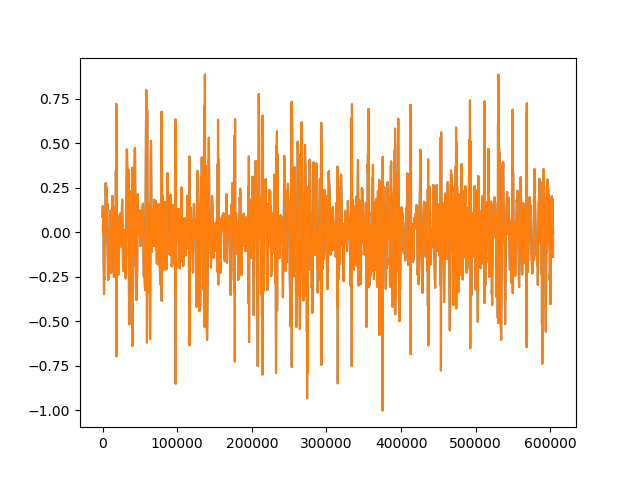

In [263]:
%matplotlib notebook
plt.plot(audio)
plt.plot(sum(components))
plt.show()

<IPython.core.display.Javascript object>


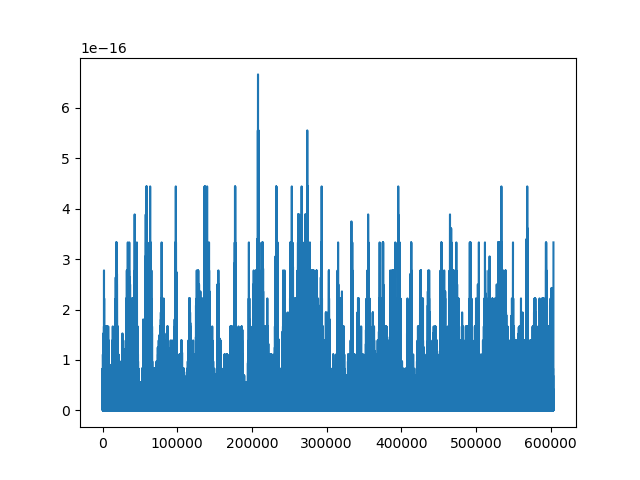

In [264]:
%matplotlib notebook
plt.plot(abs(audio - sum(components)[:len(audio)]))
plt.show()

# CQT test

<IPython.core.display.Javascript object>


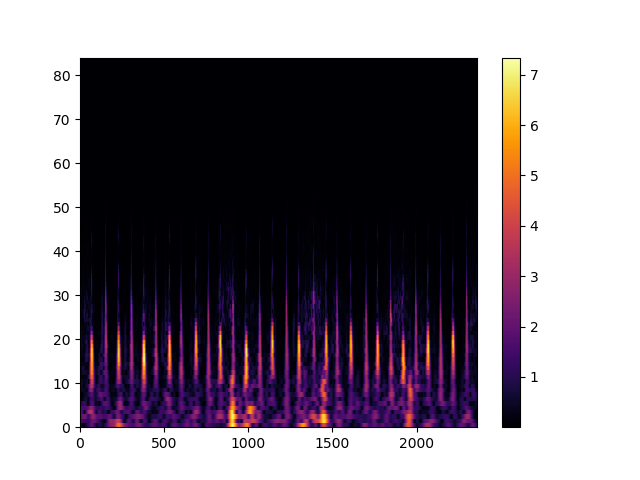

In [75]:
cqt_value = cqt(audio, sr=samplerate, hop_length=256, fmin=30, n_bins=84, 
                bins_per_octave=12, tuning=0.0, filter_scale=1, norm=1, 
                sparsity=0.00, window='hann', scale=True, pad_mode='constant', 
                res_type='fft')


%matplotlib notebook
plt.pcolormesh((abs(cqt_value) + 1e-12), cmap='inferno')
plt.colorbar()
plt.show()

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\librosa\core\constantq.py:676: UserWarning: hop_length=256 exceeds minimum CQT filter length=204.619.
This will probably cause unpleasant acoustic artifacts. Consider decreasing your hop length or increasing the frequency resolution of your CQT.
  'frequency resolution of your CQT.'.format(hop_length, min(lengths)))


603597


<IPython.core.display.Javascript object>


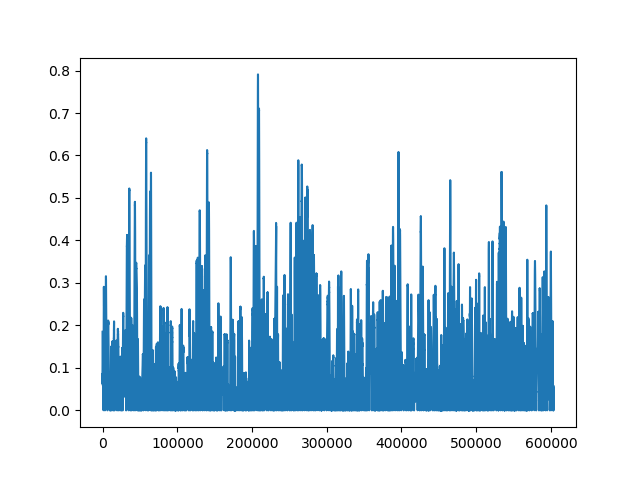

In [76]:
audio_recomp = icqt(cqt_value, sr=samplerate, hop_length=256, fmin=30, 
                bins_per_octave=12, tuning=0.0, filter_scale=1, norm=1, 
                sparsity=0.00, window='hann', scale=True, res_type='fft')

print(len(audio))
%matplotlib notebook
plt.plot(abs(audio[:len(audio_recomp)] - audio_recomp))
plt.show()

<IPython.core.display.Javascript object>


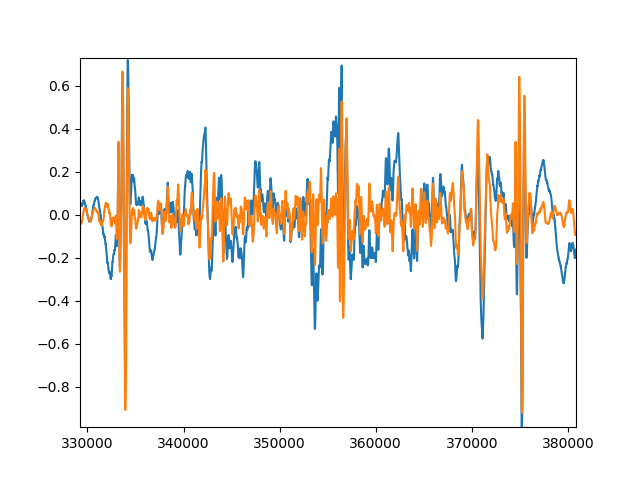

In [77]:
%matplotlib notebook
plt.plot(audio)
plt.plot(audio_recomp)
plt.show()